# Experiment - 16 June 2017 

## Task 1 - Cohort extraction

In [1]:
%matplotlib inline
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={"figure.figsize": (16, 8)}); 
np.random.seed(20170619)

In [4]:
location = 'Coll.Centre'
targets = ['NICU', 'PICU']

In [ ]:
# Read Data
H1 = pd.read_excel("H1.xlsx")
A1 = pd.read_excel("A1.xlsx")

In [ ]:
H1.to_pickle("H1.pkl")
A1.to_pickle("A1.pkl")

In [3]:
H1 = pd.read_pickle("H1.pkl")
A1 = pd.read_pickle("A1.pkl")

In [4]:
# Make subjects from two sources unique in research ID 
A1['Research.ID'] = A1['Research.ID'].add(len(H1['Research.ID'].unique()))
dataframe = pd.concat([H1, A1])
#dataframe['Research.ID']

In [246]:
# Add age column 
dataframe['DoB'] = pd.to_datetime(dataframe['DoB'], format='%y%m%d')
dataframe['Collected'] = pd.to_datetime(dataframe['Collected'], format='%y%m%d')
dataframe['age'] = (dataframe['Collected'] - dataframe['DoB']).astype('<m8[Y]')
dataframe = dataframe.sort_values(['Research.ID', 'Collected'])
dataframe.loc[:, ['Research.ID', 'DoB', 'Collected', 'age', 'SODIUM']]

In [6]:
group = dataframe.groupby(by=['Research.ID'])

Cohort selection:

   * subject older than 18
   * moved to PICU or NICU once 

In [7]:
def addcol(x, lab_values=['SODIUM']):
    cond1 = False
    
    for icu in targets:
        temp = bool(x[location].str.contains(icu).sum())
        cond1 = temp or cond1 
    
    cond2 = bool((x7['age'] < 18).sum())
    
    x['included'] = (cond1 and cond2)
    
    if x[location].iloc[0] in targets:
        x['included'] = False
    
    select = x[location].isin(targets)
    a = select.sum()
    for i in lab_values:
        labmax = i + "_max"
        labmin = i + "_min"
        if a:
            movetime = x.loc[select, "Collected"].iloc[0]
            #print(movetime)
            _max = x.loc[x["Collected"] < movetime, "SODIUM"].max()
            _min = x.loc[x["Collected"] < movetime, "SODIUM"].min()
        else:
            _max = x["SODIUM"].max()
            _min = x["SODIUM"].min()
    x[labmax] = _max
    x[labmin] = _min
    
    return x

In [8]:
data = group.apply(addcol)

In [ ]:
#print(group.get_group(969))
#print(group.get_group(969))
#print(data.loc[data['Research.ID'] == 969, ['Research.ID', location, 'included']])
#print(data.loc[data[location].isin(targets), :])

In [247]:
data.loc[data['included'], ['Research.ID', 'age', location, 'SODIUM', "SODIUM_max", "SODIUM_min", 'included']]

In [21]:
data.to_pickle("./data_2.pkl")

In [2]:
data = pd.read_pickle("./data_2.pkl")

## Task 2: Distribution and patient in ICU ratio plot 

Use lab value = "SODIUM" as an example here. 

* Plot distribution histogram of lab value 
* In each bar of the histogram, plot the ratio of patients in ICU with lab values in this range ( ICU subjects / total subjects with in this value range). Note: ICU ratio is only plotted when number of patients > 10 in case of outliers

In [248]:
lab_value = ["SODIUM"]
lab_minmax = []
for i in lab_value:
    lab_minmax.extend([i+"_min", i+"_max"])
print(lab_minmax)
#data.loc[data['Research.ID']==80, ['Research.ID', "SODIUM", 'SODIUM_max', 'SODIUM_min', location, 'age', 'included']]

['SODIUM_min', 'SODIUM_max']


### Min and Max plot seperately 

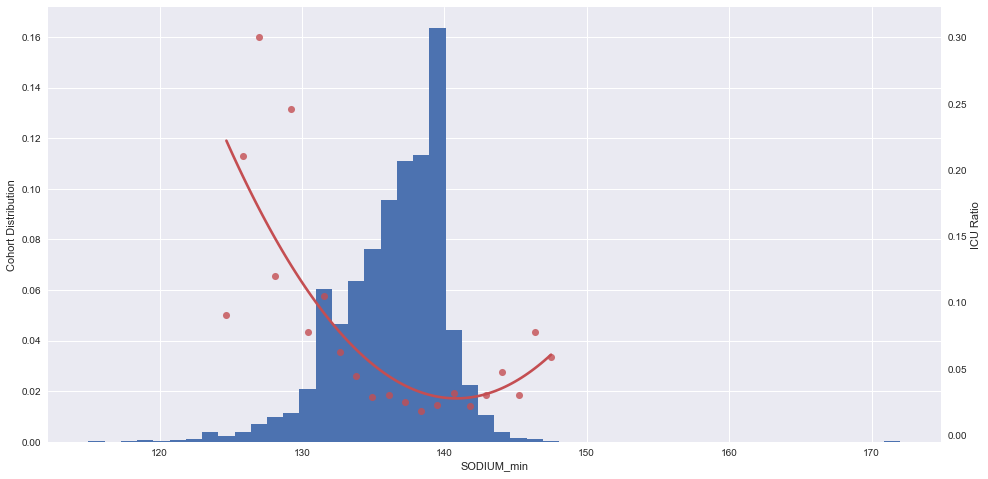

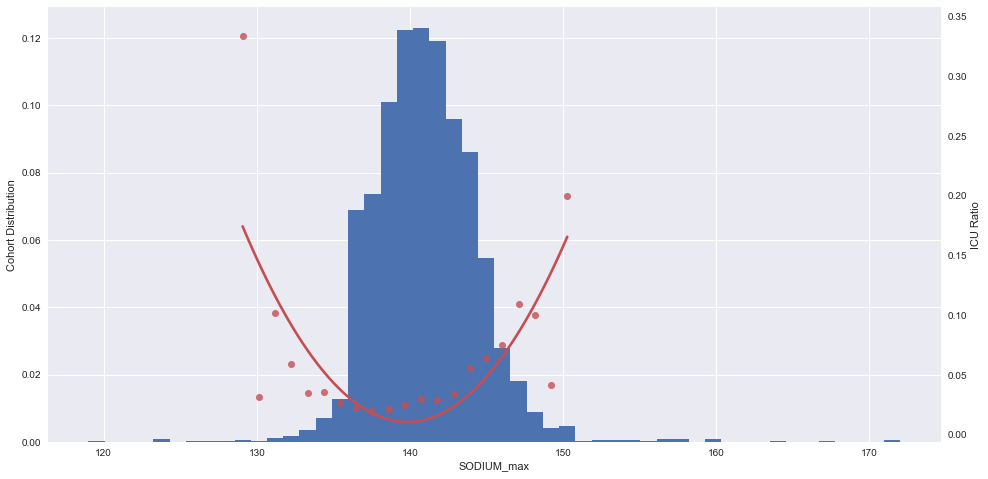

In [222]:
tenth, nintieth = np.percentile(data[lab_value].dropna(), [10, 90])

for lab in lab_minmax:
    fig, ax = plt.subplots()
    counts, bins, patches = ax.hist(data[lab].dropna(), bins=50, normed=True)
    ax.set_xbound(lower=tenth, upper=nintieth)
    ax.set_xlabel(lab)
    ax.set_ylabel("Cohort Distribution")
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    testar = []
    x = []
    y = []
    for i, reading in enumerate(bins[:-1]):
        criterion = [i and j for i, j in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x >= bins[i] and x <= bins[i+1]))]
        subjects = data.loc[criterion, 'Research.ID'].unique()
        groups = data[data['Research.ID'].isin(subjects)].groupby('Research.ID')

        if len(subjects) > 10:
            value_count = float(groups.included.agg('max').sum()) / float(len(subjects))
            x.append((bins[i] + bins[i+1]) / 2.0)
            y.append(value_count)

    ax2 = ax.twinx()

    #ax2.scatter(x=x, y=y, c='r')
    ax2.grid(False)
    x, y = pd.Series(x[1:], name=""), pd.Series(y[1:], name="")
    ax2 = sns.regplot(x=x, y=y,
                      scatter_kws={"s": 50},
                      color='r',
                      order=2, ci=None, truncate=True)
    ax2.set_ylabel("ICU Ratio")

## Task 3: Min / Max odds ratio plot

Plot ICU odds ratio

Cohort (age < 18) for value range x: (when x < 140)

|                      | Outcomes: Converted to ICU | Not converted to ICU |   |   |
|----------------------|-----------------------------|------------------------------|---|---|
|  Exposures: Max/Min value <= x    | a                           | b                            |   |   |
| Max/Min value > x | c                           | d                            |   |   |

when x >= 140 

|                      | Outcomes: Converted to ICU | Not converted to ICU |   |   |
|----------------------|-----------------------------|------------------------------|---|---|
|  Exposures: Max/Min value >= x    | a                           | b                            |   |   |
| Max/Min value < x | c                           | d                            |   |   |


Odds Ratio (OR) = (a/b) / (c/d) = (a × d) / (b × c)




In [87]:
teenagers = data.loc[data.age < 18.0, 'Research.ID'].unique()
OR_cohort = data[data['Research.ID'].isin(teenagers)].copy()
print(len(teenagers))

105603


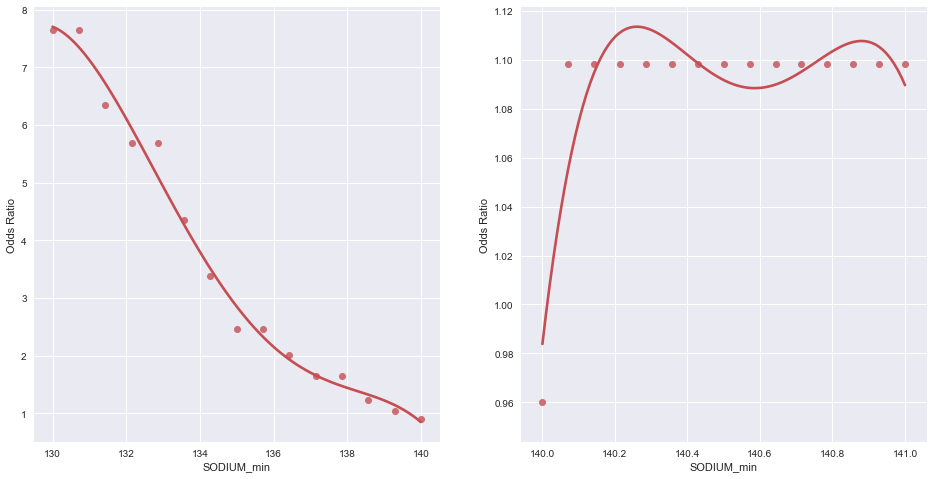

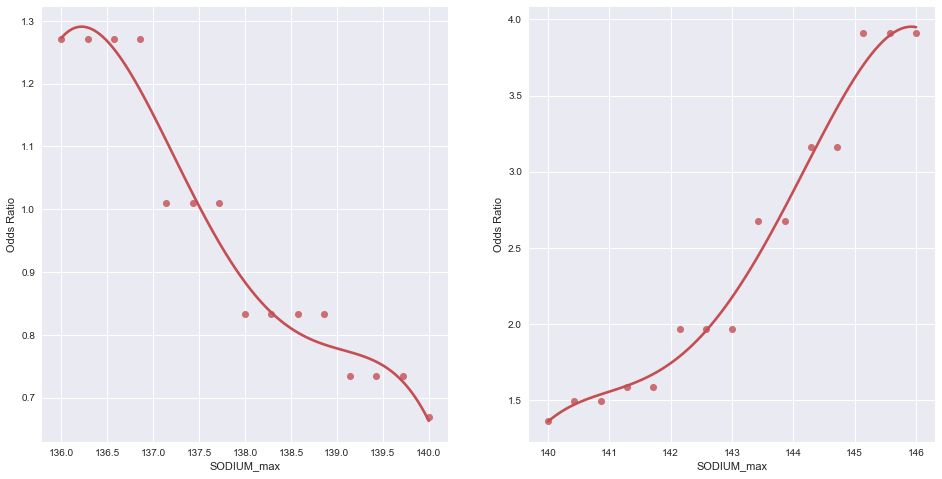

In [264]:
for lab in lab_minmax:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    tenth, nintieth = np.percentile(data[lab].dropna(), [5, 95])
    
    for i, ax in enumerate((ax1, ax2)):
        if i==0:
            x = np.linspace(tenth, 140.0, num=15)
            y = []
            for _x in x:
                
                crit_a = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x <= _x))]
                a = data.loc[crit_a, 'Research.ID'].unique()
                a = float(len(a))

                crit_b = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x <= _x))]
                b = data.loc[crit_b, 'Research.ID'].unique()
                b = float(len(b))

                crit_c = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x > _x))]
                c = data.loc[crit_c, 'Research.ID'].unique()
                c = float(len(c))

                crit_d = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x > _x))]
                d = data.loc[crit_d, 'Research.ID'].unique()
                d = float(len(d))
                
                y.append(a * d / (b * c))
            x, y = pd.Series(x[:], name=""), pd.Series(y[:], name="")
            sns.regplot(x=x, y=y,
                        scatter_kws={"s": 50},
                        color='r',
                        ax=ax, 
                        order=4, ci=None, truncate=True)
            #ax.set_xbound(lower=tenth, upper=nintieth)
            ax.set_xlabel(lab)
            ax.set_ylabel("Odds Ratio")
        else:
            x = np.linspace(140.0, nintieth, num=15)
            y = []
            for _x in x:
                
                crit_a = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x >= _x))]
                a = data.loc[crit_a, 'Research.ID'].unique()
                a = float(len(a))

                crit_b = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x >= _x))]
                b = data.loc[crit_b, 'Research.ID'].unique()
                b = float(len(b))

                crit_c = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x < _x))]
                c = data.loc[crit_c, 'Research.ID'].unique()
                c = float(len(c))

                crit_d = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x < _x))]
                d = data.loc[crit_d, 'Research.ID'].unique()
                d = float(len(d))
                
                y.append(a * d / (b * c))
            x, y = pd.Series(x[:], name=""), pd.Series(y[:], name="")
            sns.regplot(x=x, y=y,
                        scatter_kws={"s": 50},
                        color='r',
                        ax=ax,
                        order=4, ci=None, truncate=True)
            #ax.set_xbound(lower=tenth, upper=nintieth)
            ax.set_xlabel(lab)
            ax.set_ylabel("Odds Ratio")

### Task 4: Cumulative frequency plot

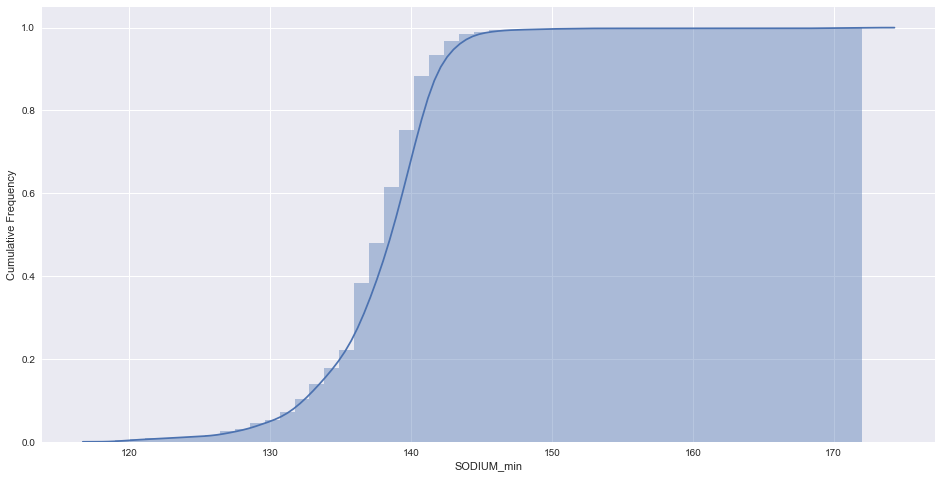

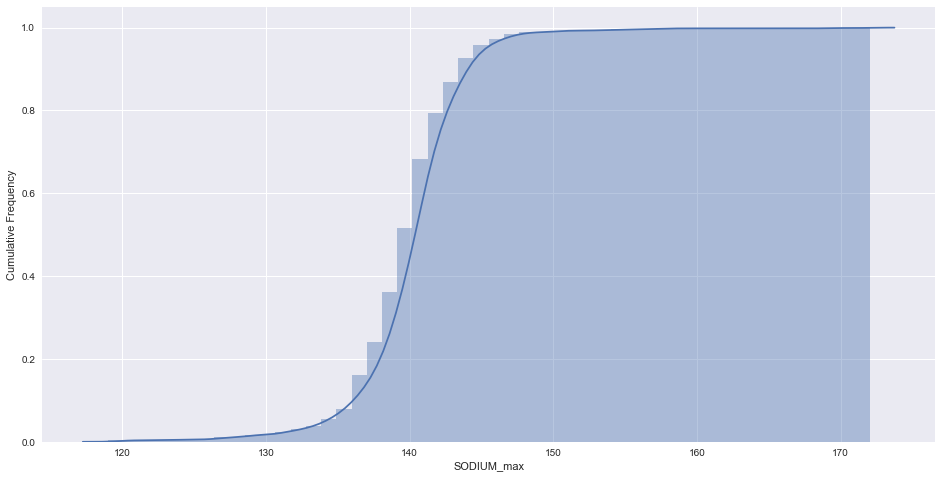

In [259]:
for lab in lab_minmax:
    fig, ax = plt.subplots()
    tenth, nintieth = np.percentile(data[lab].dropna(), [5, 95])
    
    crit_x = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x)))]
    subjects = data.loc[crit_x, 'Research.ID'].unique()
    x = []
    y = []
    for i in subjects:
        temp = np.max(data.loc[data['Research.ID']==i, lab])
        x.append(temp)
        
        temp_y = np.max(data.loc[data['Research.ID']==i, 'included'])
        y.append(temp_y)
    #print(x[:100])
    #print(y[:100])

    sns.distplot(x,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
    ax.set_xlabel(lab)
    ax.set_ylabel("Cumulative Frequency")